# Problem 5

### Code

In [1]:
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import pandas as pd
import copy

# Name: get_data_from_internet
# Purpose: Return value of data
# In: url(str)
# Out: data_df(dataframe) 
def read_data_from_online(url):

    #read content from the url
    resource = urllib.request.urlopen(url)
    content =  resource.read().decode(resource.headers.get_content_charset())
    lines=content.split("\n")
    data_list=[]
    #find the first line of the data
    for startline, line in enumerate(lines):
        if line=='    eruptions waiting':
            break
    for line in lines[startline+1:]:
        data=line.split()
        if len(data)==3:
            data_list.append([eval(n) for n in data][1:])
    data_df=pd.DataFrame(data_list, columns=["erupthins",'waiting'])
    return data_df
      

# Name: get_normal
# Purpose: Return value of multivariate Normal distribution
# In: x (array), mu (array), E (2D array)
# Out: (float)
def get_normal(x,mu,E):
    norm = 1.0 / ((2.0*np.pi)**(len(x)/2)*np.sqrt(np.linalg.det(E)))
    delta = (x - mu) # (1xN)
    #print(delta)
    #print(np.transpose(delta))
    exponent = np.dot(np.dot(delta,np.linalg.pinv(E)),np.transpose(delta))
    return norm * np.exp(-0.5 * exponent)

# Name: normalize_data
# Purpose: normalize data in a dataframe in the range [0,1]
# In: df (Pandas Dataframe)
# Out: df (Pandas Dataframe)
def normalize_data(df):
    # Number of columns
    header = df.columns.values
    # Normalize column by column
    for col in header:
        cmax = np.max(df[col])
        cmin = np.min(df[col])
        df[col] = df[col].apply(lambda r: float(r - cmin)/float(cmax - cmin))
    return df

# Name: initialize_params
# Purpose: initialize the parameters
# and the number of clusters K
# In: N (int), K (int)
# Out: pi (array), mu (array), E (2D array)
def initialize_params(N,K):
    np.random.seed(26)
    # Initialize mean vectors (one for each cluster) (KxN)
    mu = np.random.rand(K,N)
    # Initialize mixing coefficients (one for each cluster) (1xK)
    # they must be normalized
    pi = np.random.rand(K)
    pi = pi / np.sum(pi)
    # Initialize covariance matrices (one for each cluster) (NxN)
    E = list(range(K))
    for k in range(K):
        E[k] = np.identity(N)
       
    return mu,E,pi

# Name: get_gamma_z
# Purpose: calculate gamma(z_{m,k})
# In: k,m,K (int), df (dataframe) mu(2D array) E(3D array) pi(array)
# Out: gamma_zkm (float)
def get_gamma_z(k,m,df,mu,pi,E,K):
    numerator=pi[k]*get_normal(df.iloc[m].values,mu[k],E[k])
    denominator=0
    for j in range(K):
        denominator+=pi[j]*get_normal(df.iloc[m].values,mu[j],E[j])
    gamma_zkm=numerator/denominator
    return gamma_zkm

# Name: m_step
# Purpose: calculate the new pi,E,and mu
# In: df (dataframe) mu(2D array) E(3D array) pi(array) k,step(int)
# Out: mu(2D array) E(3D array) pi(array) k,step(int) EM_mu(3D array) convergence_px(array) 
def m_step(df,mu,pi,E,K,step):
    #EM
    EM_mu=[]
    convergence_px=[]
    for i in range(step):
        #print(i," out of ",step)
        for k in range(K):
            M=len(df)
            sum_gamma_Z=0
            sum_gamma_ZX=0
            sum_gamma_ZXMu=0
            for m in range(M):
                temp=get_gamma_z(k,m,df,mu,pi,E,K)
                xm=df.iloc[m].values
                sum_gamma_Z+=temp
                sum_gamma_ZX+=temp*xm
                sum_gamma_ZXMu+=temp*np.outer((xm-mu[k]),(xm-mu[k]))
            #calculate the new parameter

            pi[k]=sum_gamma_Z/M
            mu[k]= sum_gamma_ZX/sum_gamma_Z
            E[k]=sum_gamma_ZXMu/sum_gamma_Z
        px=1
        for m in range(len(df)):
            sum_N=0
            for k in range(K):
                sum_N+=pi[k]*get_normal(df.iloc[m].values,mu[k],E[k])
            px=px*sum_N
        EM_mu.append(copy.deepcopy(mu))
        #print(EM_mu)
        convergence_px.append(px)
        #print(mu[0])
    return EM_mu,mu,pi,E,convergence_px

    

#read values from online   
url="http://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat"
data_df=read_data_from_online(url)

#visulization normalize_data
df=normalize_data(data_df)
#plt.scatter(df.erupthins, df.waiting)
#plt.show()

#initialize params
N=2
K=2
mu,E,pi=initialize_params(N,K)


step=40
EM_mu,mu,pi,E,convergence_px=m_step(df,mu,pi,E,K,step)

#print(EM_mu)

## Question(a)
A plot or datafile containing your parameters {π k , μ k , Σ k } and optionally ln p(X) demonstrating nu-meric convergence after a number of training steps

### Answer 

### (1) a plot for the change of μ k (the center of the cluster) 

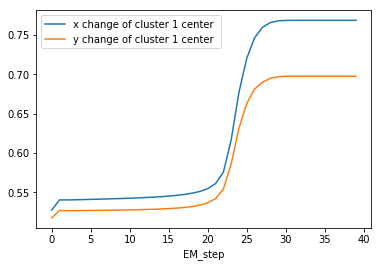

In [2]:
#plot change of the center
center=[]
for mu in EM_mu:
    center.append(mu[0])
center=np.array(center)
plt.plot(center[:,0],label='x change of cluster 1 center ')
plt.plot(center[:,1],label='y change of cluster 1 center')
plt.xlabel("EM_step")
plt.legend()
plt.show()

### (2) plot for ln p(X)

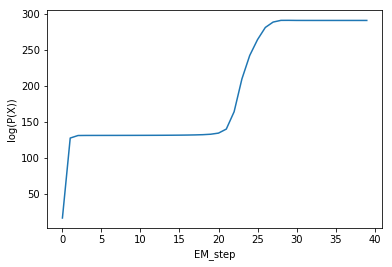

In [3]:
plt.plot(np.log(convergence_px))
plt.xlabel("EM_step")
plt.ylabel("log(P(X))")
plt.show()

## Question(b)
A plot of the predicted clusters after training superimposed on the Old Faithful dataset

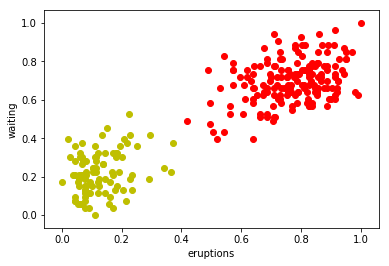

In [4]:
#plot the differnt cluster with different color
#when N=2 K=2
colors_list=['r','y','g','b','c','m']
for m in range(len(df)):
    gamma_z_list=[]
    for k in range(K):
        gamma_z=get_gamma_z(k,m,df,mu,pi,E,K)
        gamma_z_list.append(gamma_z)
    #find the max 
    label=np.argmax(np.array(gamma_z_list))
    plt.scatter(df.iloc[m].values[0],df.iloc[m].values[1],c=colors_list[label])
plt.xlabel("eruptions")
plt.ylabel("waiting")
plt.show()